# 内容

    Part1 
        1、赛题说明
        2、数据预处理
        3、数据探索分析
        4、模型构建与评估（第一性指标：accuracy）
        5、预测
        6、提交结果与得分
    Part2
        1、成本收益模式分析
        2、调整评价指标，再次构建模型（第一性指标：f1）

这是CDA数据分析网站的一个赛题，A公司希望发掘用户购买产品的行为习惯，建立产品精准营销模型，对有意向的客户进行精准营销，增加收入，减少开支。
通过混淆矩阵（Confusion matrix）来评价分类模型的准确率，准确率越高，说明正确预测出响应营销效果越好。
本次实战案例以官方公布的评分标准accuracy为目标进行参数调优。又探索了在不同成本收益模型下，选择不同的模型评估指标，最终得到最高的潜在盈利预测。

赛题网址：https://contest.cda.cn/info/id/6.html

## 第一部分

## 《产品营销模型之建置及预测》赛题说明

#### 背景
A公司有一款在线服务的P产品，公司的营销通路是100％的网络媒介。A公司希望提供30天免费的P产品后，期望顾客能正式签约购买P产品之服务。但A公司发现‚每隔1~2天便对数以万计的顾客发送电子营销文宣，不但购买率低下，甚至造成诸多客诉。同时，客户之预期获利是以人工经验评估之，没有量化或模型工具之协助，不晓得到底应该使用广告全投放还是机器学习模型来做投放?

#### 目标
A公司希望发掘用户购买产品的行为习惯，建立产品精准营销模型，对有意向的客户进行精准营销，增加收入，减少开支。

#### 评分标准
我们通过混淆矩阵（Confusion matrix）来评价分类模型的准确率。准确率越高，说明正确预测出响应营销效果越好。

#### B榜分数
实务应用中，老板是否采用你的营销方案往往不是以预测结果的正确率做为考虑‚而是以模型能带给公司多少的利润最为最终的考虑。
参与比赛的成绩以公司获得的利润结果排序，模型越赚钱者越好。为此‚我们做了以下两个假设，选手需分别将预测结果存于results_A.csv及results_B.csv。

#### 提交结果
选手以训练数据为基础，建立产品营销模型，并上传一个测试结果的档案results.csv，文档中只有两个字段，分别是客户ID以及预测客户是否会购买(Predicted_Results)的结果。

#### 字段说明

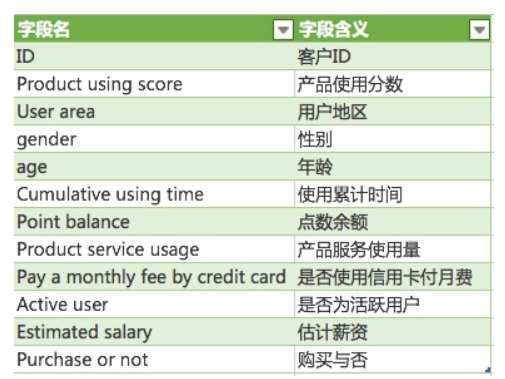

##  基于机器学习的产品购买预测

### 工具准备

In [1]:
#-------------辅助工具-------------#
import os #文档路径
import numpy as np
import pandas as pd
pd.options.display.max_columns = None  # 显示所有列
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # 取消科学计数法

from time import time #计时
import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #显示所有输出

import pickle #训练模型的保存与读取
from sklearn.externals import joblib #保存训练模型

#-------------数据可视化工具-------------#
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题
plt.rcParams['axes.unicode_minus'] = False # 解决坐标轴刻度负号乱码

#-------------数据清洗工具-------------#
from sklearn.impute import SimpleImputer #缺失值填充
from sklearn.ensemble import RandomForestRegressor #也可作为数据清洗工具，填充缺失值；
from sklearn.ensemble import RandomForestClassifier  #也可作为数据清洗工具，填充缺失值；能接受输入空间存子异常值，但不能接受空值

#-------------统计检验工具-------------#
from scipy.stats import chi2_contingency #数值型特征检验，检验特征与标签的关系
from scipy.stats import f_oneway #分类型特征检验，检验特征与标签的关系
from scipy.stats import ttest_ind #分类型特征检验，检验特征与标签的关系

#-------------数据预处理工具-------------#
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder #标签编码
from sklearn.preprocessing import OneHotEncoder #独热编码
from sklearn.preprocessing import StandardScaler #标准化

#-------------建模工具-------------#
from sklearn.model_selection import train_test_split  # 划分训练集和测试集
from sklearn.model_selection import cross_val_score #交叉验证
from sklearn.model_selection import GridSearchCV #网格搜索

import xgboost #也可作为数据清洗工具，填充缺失值；能接受输入空间存在空值
from sklearn.neural_network import MLPClassifier #多层感知神经网络


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 一、导入数据

In [2]:
train_raw_data=pd.read_csv('./df_train.csv')
test_raw_data=pd.read_csv('./df_test.csv')

In [3]:
train_raw_data.columns=['客户ID','产品使用分数','用户地区','性别','年龄','使用累计时间','点数余额','产品服务使用量','是否使用信用卡付月费','是否为活跃用户','估计薪资','购买与否']
test_raw_data.columns=['客户ID','产品使用分数','用户地区','性别','年龄','使用累计时间','点数余额','产品服务使用量','是否使用信用卡付月费','是否为活跃用户','估计薪资','购买与否']

train_raw_data.head()
print('----------')
test_raw_data.head()

,客户ID,产品使用分数,用户地区,性别,年龄,使用累计时间,点数余额,产品服务使用量,是否使用信用卡付月费,是否为活跃用户,估计薪资,购买与否
0,6518,628,?,Female,51,?,155903.82,2,1,1,71159.84,0
1,5195,696,Taipei,?,27,4,?,2,0,?,196111.35,0
2,1786,?,Taichung,Male,40,3,?,2,1,1,?,0
3,6151,?,?,Male,?,?,?,?,1,0,?,1
4,7577,?,Tainan,?,27,?,0,1,?,1,107955.67,0


----------


,客户ID,产品使用分数,用户地区,性别,年龄,使用累计时间,点数余额,产品服务使用量,是否使用信用卡付月费,是否为活跃用户,估计薪资,购买与否
0,9222,655,Taichung,Female,37,4,108862.76,?,1,0,79555.08,Withheld
1,3931,?,Taichung,?,52,9,111973.97,1,?,1,?,Withheld
2,1242,519,Taipei,?,21,1,146329.57,2,1,1,194867.27,Withheld
3,3639,?,Tainan,Male,?,?,0,2,0,0,96398.51,Withheld
4,7951,?,?,Female,33,10,138847.9,?,1,?,127256.7,Withheld


### 二、数据清洗

#### （一）数据质量检测

In [4]:
train_raw_data.info()

# 结论：多个字段的数据类型不对。字段产品使用分数、年龄、点数余额的数据类型应调整为数值型，使用累计时间的数据类型应调整是时间型。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 12 columns):
客户ID          6000 non-null int64
产品使用分数        6000 non-null object
用户地区          6000 non-null object
性别            6000 non-null object
年龄            6000 non-null object
使用累计时间        6000 non-null object
点数余额          6000 non-null object
产品服务使用量       6000 non-null object
是否使用信用卡付月费    6000 non-null object
是否为活跃用户       6000 non-null object
估计薪资          6000 non-null object
购买与否          6000 non-null int64
dtypes: int64(2), object(10)
memory usage: 562.6+ KB


In [5]:
for cate in train_raw_data.columns:
    print(cate,'的取值分布：')
    print(train_raw_data[cate].value_counts())
    print('----------------------------------')
# 结论：多个字段有错误值?

客户ID 的取值分布：
2047    1
6818    1
1257    1
2708    1
8853    1
       ..
5460    1
7509    1
1366    1
3415    1
8192    1
Name: 客户ID, Length: 6000, dtype: int64
----------------------------------
产品使用分数 的取值分布：
?      1835
850     104
667      28
684      28
714      25
       ... 
414       1
410       1
458       1
413       1
404       1
Name: 产品使用分数, Length: 440, dtype: int64
----------------------------------
用户地区 的取值分布：
Taipei      2077
?           1833
Taichung    1063
Tainan      1027
Name: 用户地区, dtype: int64
----------------------------------
性别 的取值分布：
Male      2315
?         1844
Female    1841
Name: 性别, dtype: int64
----------------------------------
年龄 的取值分布：
?     1821
35     223
36     212
37     206
40     186
      ... 
84       1
82       1
78       1
92       1
85       1
Name: 年龄, Length: 69, dtype: int64
----------------------------------
使用累计时间 的取值分布：
?     1793
2      455
9      442
8      436
4      435
3      426
5      420
1      418
7      414
6      402
10   

In [6]:
train_raw_data['客户ID'].unique().shape 

#结论：没有重复值

(6000,)

### [特征解析]
    
    【特征】
    
    客户ID         文本  #不是特征
    产品使用分数     数值
    用户地区        类别，分为3个地区
    性别          类别，分为2类(Femal Male）   
    年龄          数值  
    使用累计时间     类别，分为11等级 （0-10）
    点数余额        数值  
    产品服务使用量     类别，分为4类（1-4）
    是否使用信用卡付月费  类别，分为2类（0-1）
    是否为活跃用户      类别，分为2类（0-1）
    估计薪资          数值
    购买与否         类别  #标签
    
    【总结】
    
    总变量中：10个特征，1个标签，1列客户ID。
    特征中：4个数值型特征，6个类别型特征（3个二分类特征，3个多分类特征）
    注：年龄视情况再看要不要分箱，转化为类别特征。

#### （二）初步清洗

- 错误值处理

In [7]:
# 错误值处理
data_clean_1=train_raw_data.drop(['客户ID'],axis=1)
data_clean_1=data_clean_1.replace('?',np.nan)#填充空值
data_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
产品使用分数        4165 non-null object
用户地区          4167 non-null object
性别            4156 non-null object
年龄            4179 non-null object
使用累计时间        4207 non-null object
点数余额          4232 non-null object
产品服务使用量       4188 non-null object
是否使用信用卡付月费    4118 non-null object
是否为活跃用户       4181 non-null object
估计薪资          4161 non-null object
购买与否          6000 non-null int64
dtypes: int64(1), object(10)
memory usage: 515.8+ KB


- 转化数据类型

In [8]:
# 转化数据类型
data_clean_1['产品使用分数']=data_clean_1['产品使用分数'].astype(dtype='float')
data_clean_1['年龄']=data_clean_1['年龄'].astype(dtype='float')
data_clean_1['点数余额']=data_clean_1['点数余额'].astype(dtype='float')
data_clean_1['估计薪资']=data_clean_1['估计薪资'].astype(dtype='float')
data_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
产品使用分数        4165 non-null float64
用户地区          4167 non-null object
性别            4156 non-null object
年龄            4179 non-null float64
使用累计时间        4207 non-null object
点数余额          4232 non-null float64
产品服务使用量       4188 non-null object
是否使用信用卡付月费    4118 non-null object
是否为活跃用户       4181 non-null object
估计薪资          4161 non-null float64
购买与否          6000 non-null int64
dtypes: float64(4), int64(1), object(6)
memory usage: 515.8+ KB


- 异常值检测

没有异常值

年龄考虑分箱处理，转化为类别型特征

In [9]:
data_clean_1.describe([0.01,0.25,0.75,0.99])

,产品使用分数,年龄,点数余额,估计薪资,购买与否
count,4165.0000,4179.0000,4232.0000,4161.0000,6000.0000
mean,652.2218,38.9225,76514.0150,100127.4218,0.2038
std,97.6207,10.5695,62496.1257,57726.7147,0.4029
min,350.0000,18.0000,0.0000,90.0700,0.0000
1%,431.0000,21.0000,0.0000,1860.0460,0.0000
25%,585.0000,32.0000,0.0000,50974.5700,0.0000
50%,653.0000,37.0000,97288.7500,100950.4800,0.0000
75%,721.0000,44.0000,128347.4150,149613.7700,0.0000
99%,850.0000,72.0000,185693.9068,198145.3680,1.0000
max,850.0000,92.0000,222267.6300,199992.4800,1.0000


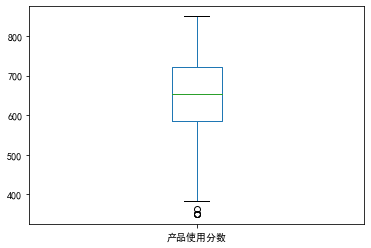

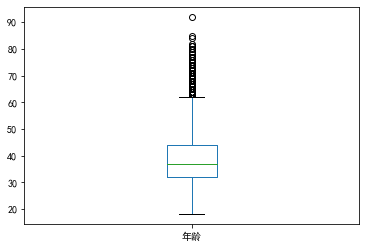

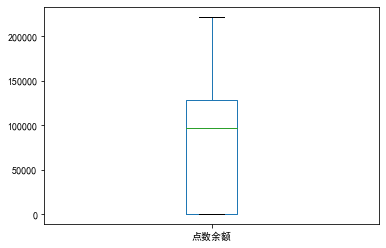

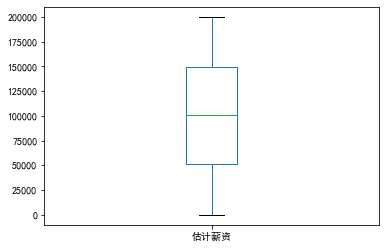

In [10]:
# 箱线图，即四分位法

cates=['产品使用分数', '年龄', '点数余额','估计薪资']
for cate in cates:
    data_clean_1[cate].plot(kind='box')
    plt.show()
    
#产品使用分数，有几个点稍微出现异常值，可以不处理
#年龄，明显有异常值，但都是属于一个人的正常年龄取值，故考虑给年龄分箱处理。

In [11]:
# 四分位法，判断是否有异常值

cates=['产品使用分数', '年龄', '点数余额','估计薪资']
for cate in cates:

    IQR=data_clean_1.describe()[cate].loc['75%']-data_clean_1.describe()[cate].loc['25%']
    low_limit=data_clean_1.describe()[cate].loc['25%']-1.5*IQR
    high_limit=data_clean_1.describe()[cate].loc['75%']+1.5*IQR
    print(cate,'的四分位法的下限值:%d'%low_limit)
    print(cate,'的四分位法的上限值:%d'%high_limit)
    print('------------')

产品使用分数 的四分位法的下限值:381
产品使用分数 的四分位法的上限值:925
------------
年龄 的四分位法的下限值:14
年龄 的四分位法的上限值:62
------------
点数余额 的四分位法的下限值:-192521
点数余额 的四分位法的上限值:320868
------------
估计薪资 的四分位法的下限值:-96984
估计薪资 的四分位法的上限值:297572
------------


In [12]:
data_clean_1[data_clean_1['年龄']>62].shape[0]
data_clean_1[data_clean_1['年龄']>62].shape[0]/data_clean_1.shape[0]

#注：年龄异常值的样本占总量2.5%

148

0.024666666666666667

- 缺失值填充

XGBoost算法填充

填充顺序：先分类型特征，再数值型特征。

#填充顺序：'产品使用分数', '年龄', '点数余额','估计薪资'

#填充顺序：'用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户'

In [13]:
data_clean_1.columns

Index(['产品使用分数', '用户地区', '性别', '年龄', '使用累计时间', '点数余额', '产品服务使用量', '是否使用信用卡付月费',
       '是否为活跃用户', '估计薪资', '购买与否'],
      dtype='object')

（1）分类特征填充

In [14]:
#构造特征空间与标签

fill_data=data_clean_1.copy()

#分类型缺失值填充为99

cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']
fill_data[cates]=fill_data[cates].fillna('99')
fill_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
产品使用分数        4165 non-null float64
用户地区          6000 non-null object
性别            6000 non-null object
年龄            4179 non-null float64
使用累计时间        6000 non-null object
点数余额          4232 non-null float64
产品服务使用量       6000 non-null object
是否使用信用卡付月费    6000 non-null object
是否为活跃用户       6000 non-null object
估计薪资          4161 non-null float64
购买与否          6000 non-null int64
dtypes: float64(4), int64(1), object(6)
memory usage: 515.8+ KB


In [15]:
# 构造算法填充的特征，独热编码，删除cate-99的特征

region_features=pd.get_dummies(fill_data['用户地区'],prefix='用户地区')
region_features=region_features.drop(['用户地区_99'],axis=1)

sex_features=pd.get_dummies(fill_data['性别'],prefix='性别')
sex_features=sex_features.drop(['性别_99'],axis=1)

usetime_features=pd.get_dummies(fill_data['使用累计时间'],prefix='使用累计时间')
usetime_features=usetime_features.drop(['使用累计时间_99'],axis=1)

service_features=pd.get_dummies(fill_data['产品服务使用量'],prefix='产品服务使用量')
service_features=service_features.drop(['产品服务使用量_99'],axis=1)

credict_features=pd.get_dummies(fill_data['是否使用信用卡付月费'],prefix='是否使用信用卡付月费')
credict_features=credict_features.drop(['是否使用信用卡付月费_99'],axis=1)

active_features=pd.get_dummies(fill_data['是否为活跃用户'],prefix='是否为活跃用户')
active_features=active_features.drop(['是否为活跃用户_99'],axis=1)

In [16]:
#构造算法填充的标签，序列编码


cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']

y_data=fill_data[cates]
y_data['用户地区']=y_data['用户地区'].replace('Taipei',0)
y_data['用户地区']=y_data['用户地区'].replace('Taichung',1)
y_data['用户地区']=y_data['用户地区'].replace('Tainan',2)

y_data['性别']=y_data['性别'].replace('Male',0)
y_data['性别']=y_data['性别'].replace('Female',1)

y_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

,用户地区,性别,使用累计时间,产品服务使用量,是否使用信用卡付月费,是否为活跃用户
0,99,1,99,2,1,1
1,0,99,4,2,0,99
2,1,0,3,2,1,1
3,99,0,99,99,1,0
4,2,99,99,1,99,1


In [17]:
# 填充

cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']

x_cates=['产品使用分数', '年龄', '点数余额','估计薪资']

dummies_f7=[ region_features,sex_features,usetime_features,service_features,credict_features,active_features,fill_data[x_cates] ]

for i in range(6):

    print('填充有缺失值的特征：',cates[i])
    print('第一步：构造特征与标签--------------------')

    Y=y_data[cates[i]]  #Serise
    Y_train=Y[Y!='99'] #没有缺失值，用于建模
    Y_test=Y[Y=='99']  #缺失值，待预测   
    
    objs=[ region_features,sex_features,usetime_features,service_features,credict_features,active_features,fill_data[x_cates] ]
    df=pd.concat(objs,axis=1)    
    ob=list(dummies_f7[i].columns)
    X=df.drop(labels=ob,axis=1)
    X_train=X[Y!='99']
    X_test=X[Y=='99']


    print('第二步：建模与预测填充------------------------')
    times=time()
    xgb_fill=xgboost.XGBClassifier(max_depth=3,n_estimators=190)
    xgb_fill.fit(X_train,Y_train)
    Y_predict=xgb_fill.predict(X_test)
    print('运行时间：%s'% datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))
    #预测结果赋值到缺失值地方
    y_data[ cates[i] ][ y_data[ cates[i] ]=='99' ]=Y_predict
    
    #保存模型
    j=str(i)
    modelname=r'xgb_fill_'+j+'.model'
    model_file = open(modelname, 'wb')
    pickle.dump(xgb_fill, model_file)
    model_file.close()

填充有缺失值的特征： 用户地区
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=190, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

运行时间：00:04:368687
填充有缺失值的特征： 性别
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=190, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

运行时间：00:01:416508
填充有缺失值的特征： 使用累计时间
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=190, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

运行时间：00:13:996128
填充有缺失值的特征： 产品服务使用量
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=190, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

运行时间：00:05:822377
填充有缺失值的特征： 是否使用信用卡付月费
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=190, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

运行时间：00:01:290212
填充有缺失值的特征： 是否为活跃用户
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=190, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

运行时间：00:01:522163


In [18]:
y_data.head()

,用户地区,性别,使用累计时间,产品服务使用量,是否使用信用卡付月费,是否为活跃用户
0,1,1,2,2,1,1
1,0,1,4,2,0,0
2,1,0,3,2,1,1
3,0,0,3,1,1,0
4,2,0,9,1,1,1


In [20]:
data_clean_2=data_clean_1.copy()
data_clean_2.info()
cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']
print('--------------------')
data_clean_2[cates]=y_data  #将分类型特征填充结果赋值给data_clean_2
data_clean_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
产品使用分数        4165 non-null float64
用户地区          4167 non-null object
性别            4156 non-null object
年龄            4179 non-null float64
使用累计时间        4207 non-null object
点数余额          4232 non-null float64
产品服务使用量       4188 non-null object
是否使用信用卡付月费    4118 non-null object
是否为活跃用户       4181 non-null object
估计薪资          4161 non-null float64
购买与否          6000 non-null int64
dtypes: float64(4), int64(1), object(6)
memory usage: 515.8+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
产品使用分数        4165 non-null float64
用户地区          6000 non-null object
性别            6000 non-null object
年龄            4179 non-null float64
使用累计时间        6000 non-null object
点数余额          4232 non-null float64
产品服务使用量       6000 non-null object
是否使用信用卡付月费    6000 non-null object
是否为活跃用户       6000 non-null ob

(2)数值型特征填充

In [21]:
#构造特征空间与标签

cates=['产品使用分数', '年龄', '点数余额','估计薪资']
y4_data=data_clean_2[cates]

cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']
ohe_fill=OneHotEncoder().fit( data_clean_2[cates] )
result=ohe_fill.transform( data_clean_2[cates] )
df_catefeature=pd.DataFrame(result.toarray(),columns=ohe_fill.get_feature_names())

model_file = open(r'ohe_fill.model', 'wb')
pickle.dump(ohe_fill, model_file)
model_file.close()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [22]:
df_catefeature.shape
df_catefeature.head()

(6000, 24)

,x0_0.0,x0_1.0,x0_2.0,x1_0.0,x1_1.0,x2_0.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0,x2_5.0,x2_6.0,x2_7.0,x2_8.0,x2_9.0,x2_10.0,x3_1.0,x3_2.0,x3_3.0,x3_4.0,x4_0.0,x4_1.0,x5_0.0,x5_1.0
0,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
1,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000
2,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
3,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000
4,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000


In [23]:
y4_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
产品使用分数    4165 non-null float64
年龄        4179 non-null float64
点数余额      4232 non-null float64
估计薪资      4161 non-null float64
dtypes: float64(4)
memory usage: 187.6 KB


In [24]:
# 填充

cates=['产品使用分数', '年龄', '点数余额','估计薪资']
dummies_f7=[ data_clean_2[cates] ,df_catefeature ]

for i in range(4):
    
    print('填充有缺失值的特征：',cates[i])
    print('第一步：构造特征与标签--------------------')

    Y=y4_data[cates[i]]  #Serise
    Y_train=Y[Y.notnull()] #没有缺失值，用于建模
    Y_test=Y[Y.isnull()]  #缺失值，待预测
    
    
    objs=[ data_clean_2[cates] ,df_catefeature ]
    df=pd.concat(objs,axis=1)    
    ob=cates[i]
    X=df.drop(labels=ob,axis=1)
    X_train=X[Y.notnull()]
    X_test=X[Y.isnull()]

    print('第二步：建模与预测填充------------------------')
    times=time()
    xgbr_fill=xgboost.XGBRegressor(max_depth=3,n_estimators=190,objective='reg:squarederror')
    xgbr_fill.fit(X_train,Y_train)
    Y_predict=xgbr_fill.predict(X_test)
    print('运行时间：%s'% datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))
    #预测结果赋值到缺失值地方
    y4_data[ cates[i] ][ y4_data[ cates[i] ].isnull() ]=Y_predict
    
    #保存模型
    j=str(i)
    modelname=r'xgbr_fill_'+j+'.model'
    model_file = open(modelname, 'wb')
    pickle.dump(xgbr_fill, model_file)
    model_file.close()

填充有缺失值的特征： 产品使用分数
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=190,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

运行时间：00:01:373057
填充有缺失值的特征： 年龄
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=190,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

运行时间：00:01:460995
填充有缺失值的特征： 点数余额
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=190,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

运行时间：00:01:374387
填充有缺失值的特征： 估计薪资
第一步：构造特征与标签--------------------
第二步：建模与预测填充------------------------


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=190,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

运行时间：00:01:368939


In [25]:
y4_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
产品使用分数    6000 non-null float64
年龄        6000 non-null float64
点数余额      6000 non-null float64
估计薪资      6000 non-null float64
dtypes: float64(4)
memory usage: 187.6 KB


In [26]:
data_clean_3=data_clean_2.copy()
data_clean_3.info()
cates=['产品使用分数', '年龄', '点数余额','估计薪资']
print('--------------------')
data_clean_3[cates]=y4_data  #将数值型特征填充结果赋值给data_clean_3
data_clean_3.info()

data_clean_4=data_clean_3.copy()
data_clean_4['客户ID']=train_raw_data['客户ID']
data_clean_4.to_csv('./clean_df_train.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
产品使用分数        4165 non-null float64
用户地区          6000 non-null object
性别            6000 non-null object
年龄            4179 non-null float64
使用累计时间        6000 non-null object
点数余额          4232 non-null float64
产品服务使用量       6000 non-null object
是否使用信用卡付月费    6000 non-null object
是否为活跃用户       6000 non-null object
估计薪资          4161 non-null float64
购买与否          6000 non-null int64
dtypes: float64(4), int64(1), object(6)
memory usage: 515.8+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
产品使用分数        6000 non-null float64
用户地区          6000 non-null object
性别            6000 non-null object
年龄            6000 non-null float64
使用累计时间        6000 non-null object
点数余额          6000 non-null float64
产品服务使用量       6000 non-null object
是否使用信用卡付月费    6000 non-null object
是否为活跃用户       6000 non-null ob